In [1]:
import re
import os
import joblib
import pandas as pd
import numpy as np

def inverse_utility(U, threshold, u_type, u_order):
    if u_type == 1:
        return threshold  # CE is the quantile at expected U
    elif u_type == 2:
        return threshold - (threshold**u_order * (1 - U)**u_order)**(1/u_order)
    else:
        return threshold + (1/u_order) * np.log((1 + np.exp(-u_order * (1 - threshold))) / U - 1)

def load_and_process_joblibs(joblib_dir, output_path):
    eval_keys = ['Neutral_Obj', 'RewUtility_Obj', 'RiskAware_Obj', 'RI_Obj_RewUtility_to_Neutral', 
                 'DF_Obj_RewUtility_to_Neutral', 'RI_Obj_RiskAware_to_Neutral', 'DF_Obj_RiskAware_to_Neutral', 
                 'Neutral_Rew', 'RewUtility_Rew', 'RiskAware_Rew', 'RI_Rew_Neutral_to_RewUtility', 
                 'DF_Rew_Neutral_to_RewUtility', 'RI_Rew_Neutral_to_RiskAware', 'DF_Rew_Neutral_to_RiskAware',
                 'Neutral_CE', 'RewUtility_CE', 'RiskAware_CE']
    results = {key: {} for key in eval_keys}
    averages = {key: {} for key in eval_keys}

    # Group files by shared key (parameters without the type)
    joblib_files = [f for f in os.listdir(joblib_dir) if f.endswith('.joblib')]
    grouped_files = {}
    for file_name in joblib_files:
        key_value = file_name.rsplit('_', 1)[0]
        if key_value not in grouped_files:
            grouped_files[key_value] = []
        grouped_files[key_value].append(file_name)

     # Regex to extract u_type and u_order from filename
    pattern = re.compile(r"ut\((\d+),\s*([\d.]+)\)")

    for count, (key_value, file_group) in enumerate(grouped_files.items(), 1):
        neutral_file = [f for f in file_group if 'Neutral' in f]
        rewutility_file = [f for f in file_group if 'RewUtility' in f]
        riskaware_file = [f for f in file_group if 'RiskAware' in f]

        if not neutral_file or not riskaware_file:
            print(f"Skipping {key_value}: All (Neutral, RewUtility, and RiskAware) files are required.")
            continue

        # Load the joblib files
        neutral_data = joblib.load(os.path.join(joblib_dir, neutral_file[0]))
        rewutility_data = joblib.load(os.path.join(joblib_dir, rewutility_file[0]))
        riskaware_data = joblib.load(os.path.join(joblib_dir, riskaware_file[0]))

        # Extract values
        neutral_rew, neutral_obj = neutral_data
        rewutility_rew, rewutility_obj = rewutility_data
        riskaware_rew, riskaware_obj = riskaware_data

        # Compute results
        results['Neutral_Obj'][key_value] = np.mean(neutral_obj)
        results['RewUtility_Obj'][key_value] = np.mean(rewutility_obj)
        results['RiskAware_Obj'][key_value] = np.mean(riskaware_obj)
        results['Neutral_Rew'][key_value] = np.mean(neutral_rew)
        results['RewUtility_Rew'][key_value] = np.mean(rewutility_rew)
        results['RiskAware_Rew'][key_value] = np.mean(riskaware_rew)

        # Extract u_type and u_order from the filename
        # Compute certainty equivalents using inverse utility function
        match = pattern.search(key_value)
        if match:
            u_type, u_order = int(match.group(1)), float(match.group(2))
        else:
            print(f"Skipping {key_value}: Could not extract utility parameters.")
            continue
        results['Neutral_CE'][key_value] = inverse_utility(np.mean(neutral_obj), threshold=0.1, u_type=u_type, u_order=u_order)
        results['RewUtility_CE'][key_value] = inverse_utility(np.mean(rewutility_obj), threshold=0.1, u_type=u_type, u_order=u_order)
        results['RiskAware_CE'][key_value] = inverse_utility(np.mean(riskaware_obj), threshold=0.1, u_type=u_type, u_order=u_order)

        improve_obj_rn = 0
        improve_obj_un = 0
        improve_rew_nr = 0
        improve_rew_nu = 0

        if results['Neutral_Obj'][key_value] != 0:
            improve_obj_rn = 100 * (results['RiskAware_Obj'][key_value] - results['Neutral_Obj'][key_value]) / results['Neutral_Obj'][key_value]
        diff_obj_rn = len(neutral_rew) * (results['RiskAware_Obj'][key_value] - results['Neutral_Obj'][key_value])
        results['RI_Obj_RiskAware_to_Neutral'][key_value] = improve_obj_rn
        results['DF_Obj_RiskAware_to_Neutral'][key_value] = diff_obj_rn

        if results['Neutral_Obj'][key_value] != 0:
            improve_obj_un = 100 * (results['RewUtility_Obj'][key_value] - results['Neutral_Obj'][key_value]) / results['Neutral_Obj'][key_value]
        diff_obj_un = len(neutral_rew) * (results['RewUtility_Obj'][key_value] - results['Neutral_Obj'][key_value])
        results['RI_Obj_RewUtility_to_Neutral'][key_value] = improve_obj_un
        results['DF_Obj_RewUtility_to_Neutral'][key_value] = diff_obj_un

        if results['RiskAware_Rew'][key_value] != 0:
            improve_rew_nr = 100 * (results['Neutral_Rew'][key_value] - results['RiskAware_Rew'][key_value]) / results['RiskAware_Rew'][key_value]
        diff_rew_nr = len(neutral_rew) * (results['Neutral_Rew'][key_value] - results['RiskAware_Rew'][key_value])
        results['RI_Rew_Neutral_to_RiskAware'][key_value] = improve_rew_nr
        results['DF_Rew_Neutral_to_RiskAware'][key_value] = diff_rew_nr

        if results['RewUtility_Rew'][key_value] != 0:
            improve_rew_nu = 100 * (results['Neutral_Rew'][key_value] - results['RewUtility_Rew'][key_value]) / results['RewUtility_Rew'][key_value]
        diff_rew_nu = len(neutral_rew) * (results['Neutral_Rew'][key_value] - results['RewUtility_Rew'][key_value])
        results['RI_Rew_Neutral_to_RewUtility'][key_value] = improve_rew_nu
        results['DF_Rew_Neutral_to_RewUtility'][key_value] = diff_rew_nu

        print(f"{count} / {len(grouped_files)}: {key_value} ---> MEAN-Rel-RN: {improve_obj_rn}")

        # Extract parameters for averages (e.g., df, nt, etc.)
        for _, value in zip(['df', 'nt', 'ns', 'ng', 'nc', 'ut', 'th', 'fr'], key_value.split('_')):
            param_key = f'{value}'
            for i, avg_key in enumerate(eval_keys):
                if param_key not in averages[avg_key]:
                    averages[avg_key][param_key] = []
                averages[avg_key][param_key].append(results[avg_key][key_value])

    # Save results to Excel
    df1 = pd.DataFrame(results)
    df1.index.name = 'Key'
    df1.to_excel(os.path.join(output_path, 'res_inf.xlsx'))

    df2 = pd.DataFrame({
        f'MEAN-{key.capitalize()}': {k: np.mean(v) if v else 0 for k, v in avg.items()} for key, avg in averages.items()
    })
    df2.index.name = 'Key'
    df2.to_excel(os.path.join(output_path, 'resavg_inf.xlsx'))



In [2]:
# Example usage
joblib_dir = "./planning-infinite/"  # Path to the directory containing joblib files
output_path = "./planning-infinite/"  # Path to save the Excel files

load_and_process_joblibs(joblib_dir, output_path)

1 / 4536: df0.9_nt100_ns4_ng10_nc5_ut(2, 4)_th0.3_fr0.3 ---> MEAN-Rel-RN: 57.5614300195553
2 / 4536: df0.9_nt100_ns3_ng10_nc3_ut(1, 0)_th0.3_fr0.5 ---> MEAN-Rel-RN: 0
3 / 4536: df0.9_nt100_ns4_ng10_nc4_ut(3, 4)_th0.9_fr0.5 ---> MEAN-Rel-RN: 10.92581013600151
4 / 4536: df0.95_nt100_ns2_ng10_nc5_ut(2, 8)_th0.1_fr0.1 ---> MEAN-Rel-RN: -25.66341838406964
5 / 4536: df0.9_nt100_ns3_ng10_nc4_ut(1, 0)_th0.8_fr0.1 ---> MEAN-Rel-RN: 0
6 / 4536: df0.95_nt100_ns4_ng10_nc5_ut(1, 0)_th0.7_fr0.3 ---> MEAN-Rel-RN: 0
7 / 4536: df0.9_nt100_ns3_ng10_nc4_ut(3, 4)_th0.5_fr0.1 ---> MEAN-Rel-RN: -0.0327462979928375
8 / 4536: df0.95_nt100_ns5_ng10_nc4_ut(2, 16)_th0.7_fr0.3 ---> MEAN-Rel-RN: 33.85927637672941
9 / 4536: df0.95_nt100_ns3_ng10_nc3_ut(3, 16)_th0.7_fr0.1 ---> MEAN-Rel-RN: -6.652212679309881
10 / 4536: df0.9_nt100_ns4_ng10_nc4_ut(3, 8)_th0.2_fr0.1 ---> MEAN-Rel-RN: -1.6046043677618982
11 / 4536: df0.9_nt100_ns3_ng10_nc5_ut(2, 8)_th0.4_fr0.5 ---> MEAN-Rel-RN: 21.041746394268493
12 / 4536: df0.9_nt100

Mean = 41.34358919791314
Min = -78.43832677996899
Max = 900.0
Portion below zero: 0.3201058201058201
Histogram saved to ./planning-infinite/histogram_plot_RI_Obj_RiskAware_to_Neutral.png


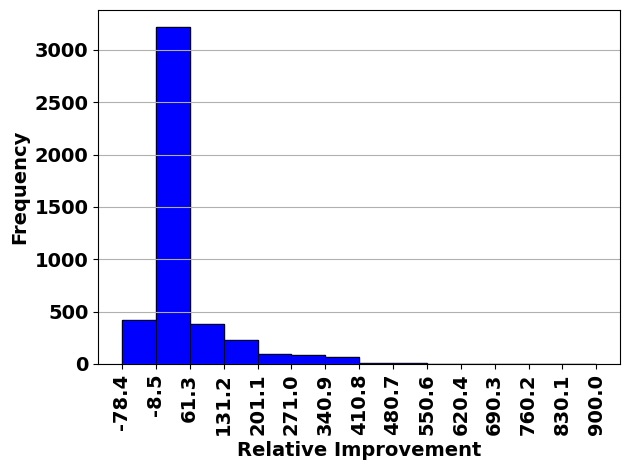

Mean = -22.257126802464164
Min = -77.61766681933229
Max = 16.57309648499643
Portion below zero: 0.5599647266313933
Histogram saved to ./planning-infinite/histogram_plot_RI_Rew_Neutral_to_RiskAware.png


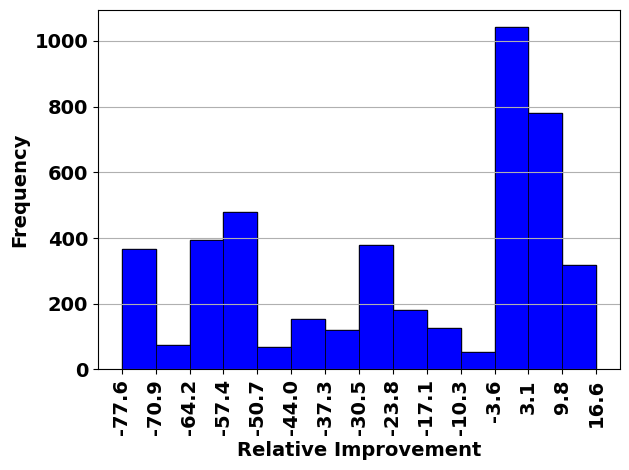

Mean = 5.410847560929667
Min = -89.0
Max = 700.0
Portion below zero: 0.4281305114638448
Histogram saved to ./planning-infinite/histogram_plot_RI_Obj_RewUtility_to_Neutral.png


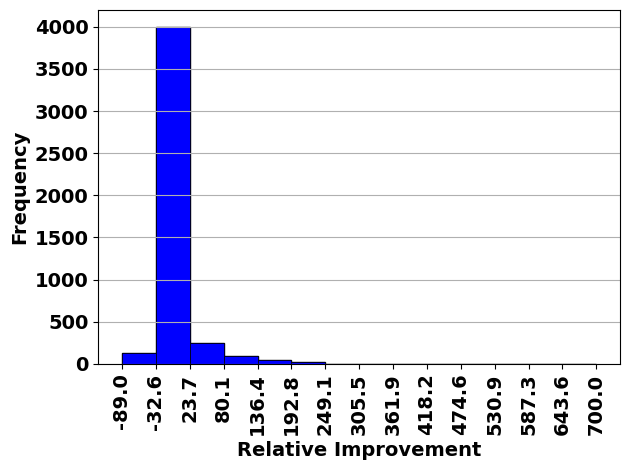

Mean = -1.1621508900136504
Min = -77.75601385378837
Max = 235.777900749858
Portion below zero: 0.5119047619047619
Histogram saved to ./planning-infinite/histogram_plot_RI_Rew_Neutral_to_RewUtility.png


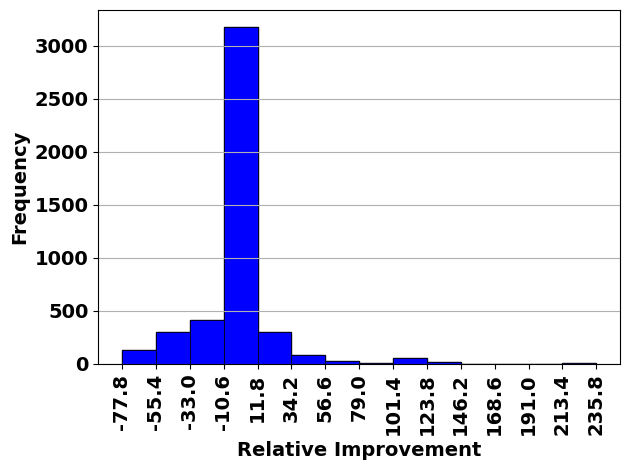

Mean = 0.2030776404097692
Min = -2.945472114613013
Max = 10.0
Portion below zero: 0.3201058201058201
Histogram saved to ./planning-infinite/histogram_plot_DF_Obj_RiskAware_to_Neutral.png


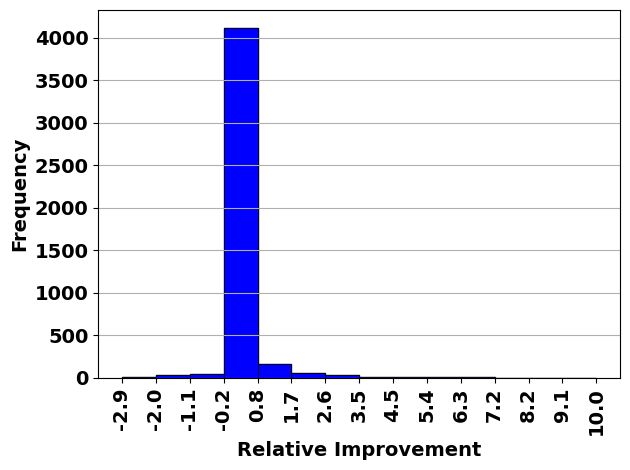

Mean = -0.2840938570000372
Min = -1.829127980004427
Max = 0.07313750798777795
Portion below zero: 0.5599647266313933
Histogram saved to ./planning-infinite/histogram_plot_DF_Rew_Neutral_to_RiskAware.png


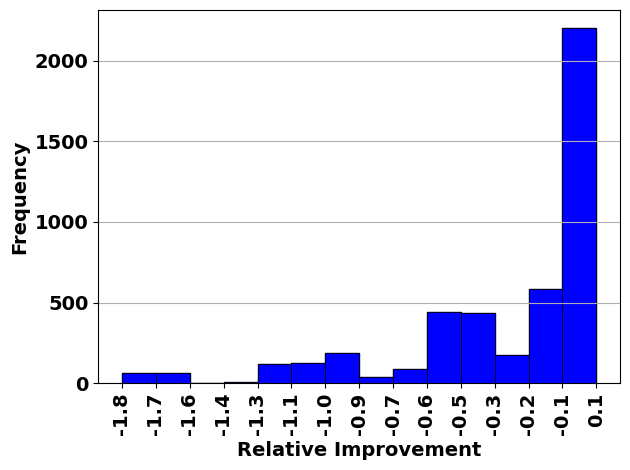

Mean = 0.06113529073463153
Min = -4.000000000000001
Max = 4.436961491893697
Portion below zero: 0.4281305114638448
Histogram saved to ./planning-infinite/histogram_plot_DF_Obj_RewUtility_to_Neutral.png


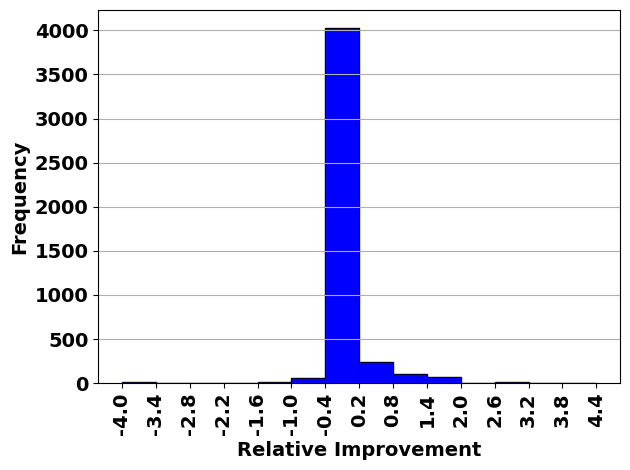

Mean = -0.03542127519322836
Min = -1.672007667353088
Max = 0.9454833552329823
Portion below zero: 0.5119047619047619
Histogram saved to ./planning-infinite/histogram_plot_DF_Rew_Neutral_to_RewUtility.png


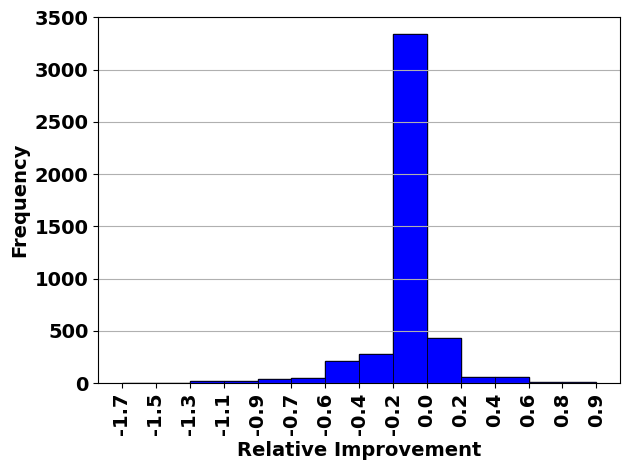

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

base_path = './planning-infinite'
file_name = 'res_inf.xlsx'
df = pd.read_excel(f'{base_path}/{file_name}')
target_labels = ['RI_Obj_RiskAware_to_Neutral', 'RI_Rew_Neutral_to_RiskAware', 
                 'RI_Obj_RewUtility_to_Neutral', 'RI_Rew_Neutral_to_RewUtility',
                 'DF_Obj_RiskAware_to_Neutral', 'DF_Rew_Neutral_to_RiskAware', 
                 'DF_Obj_RewUtility_to_Neutral', 'DF_Rew_Neutral_to_RewUtility'] 

for target_label in target_labels:
    filtered_df = df[df[target_label] <= 5000]
    y = filtered_df[target_label]

    # y = df[target_label]

    print(f'Mean = {y.mean()}')
    min_val = y.min()
    print(f'Min = {min_val}')
    max_val = y.max()
    print(f'Max = {max_val}')
    print(f"Portion below zero: {sum(y.values < 0)/len(y)}")

    # Plot the histogram
    bins = list(np.linspace(min_val, max_val, num=15))
    plt.hist(y, bins=bins, edgecolor='black')

    # Format the x-axis to have one decimal place
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    plt.xticks(bins)

    plt.xticks(fontsize=14, fontweight='bold', rotation=90)
    plt.yticks(fontsize=14, fontweight='bold')

    # Reduce the whitespace between bins
    plt.hist(y, bins=bins, edgecolor='black', linewidth=0.5, color='blue')

    plt.grid(axis='y')
    plt.xlabel('Relative Improvement', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')

    plt.tight_layout()
    output_path = f'{base_path}/histogram_plot_{target_label}.png'
    plt.savefig(output_path)
    print(f"Histogram saved to {output_path}")
    plt.show()
